# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import gc # memory control

sns.set(style="whitegrid")
plt.style.use('seaborn')

In [2]:
## import data
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
## Extract needed columns
## race: whether name sounds white or black
## call: whether the resume receives a call from employers
## firstnmae: firstname
cols = ['firstname', 'race', 'call']
df = data[cols].copy()

print("sample size is:", df.shape[0])
df.head()

sample size is: 4870


,firstname,race,call
0,Allison,w,0.0
1,Kristen,w,0.0
2,Lakisha,b,0.0
3,Latonya,b,0.0
4,Carrie,w,0.0


In [4]:
## number of callbacks for black-sounding names and white-sounding names
df.groupby('race')['call'].sum()

race
b    157.0
w    235.0
Name: call, dtype: float32

In [5]:
## split into sub-samples based on race
wdf = df[df.race=='w']
bdf = df[df.race=='b']

## array of values of sub-samples
awdf = wdf['call'].values
abdf = bdf['call'].values

## length of arrays
len(awdf), len(abdf)

(2435, 2435)

# Q1 & Q2. What test is appropriate for this problem? Does CLT apply? What are the null and alternate hypothesis? 
 
Sample size is 4870 and is larger than 30 which is commonly accepted as threshold number for CLT. Therefore, __we can apply CLT__. As to the assessment of the problem, this is where __siginificance tests__ can play a role. Because by definition, significance tests tell us whether an observed effect, such as difference between two means or a correlation between two variables, could reasonably __occur "just by chance"__ in selecting a random sample. If not, we have evidence that the effect observed in the sample reflects an effect that is present in the population. We can perform this test with __permutation tests__. However, to apply this method, we need an important assumption that the observations are exchangeable under the null hypothesis. In light of our case, __null hypothesis (H$_o$) is: there is NO significant racial discrimination in the job market__. and __alternative hypothesis (H$_a$) is: "there is significant racial discrimination in the job market__. Back to the theoretical side, under our null hypothesis, that is if we remove race tag, all observations are exchangeable; thus letting us use permutation test. To begine with, we need to set a statistic that measures the effect of discrimination. This case, it will be "proportion" of call within a racial group.

With the same spirit, we can perform __chi-squared test__ to test null hypothesis. The chi-squared test is used to determine whether there is a significant difference between the expected frequencies and the observed frequencies in one or more categories. The purpose of the test is to evaluate how likely the observations that are made would be, assuming the null hypothesis is true.

# Q3. Compute margin of error, confidence interval, and p-value. 

### Permutation test
Before we start, let me clear one terminology. The margin of error for a particular statistic of interest is usually defined as the radius (or half the width) of the confidence interval for that statistic.

In [6]:
## helpfer function
def draw_perm_reps(obs1, obs2, size=1):
    """Draw permutation replicates by given function
    Input: 1) obs1: observations of 1d array or list of first group ('w')
           2) obs2: observations of 1d array or list of second group ('b')
           3) size: size of return array of replicates
    Output: 1d array of repllicates
    """
    ## helpfer function that generates replicate of a sample
    def permutation_sample(obs1, obs2):
        """Generate a permutation sample from two data sets.
        Input: two arrays of differnt groups ('w', 'b')
        output: permuted data arrays
        """
        ## concatenate the data sets: data
        data = np.concatenate([obs1, obs2])
        ## permute the concatenated array: permuted_data
        permuted_data = np.random.permutation(data)
        # Split the permuted array into two: perm_sample_1, perm_sample_2
        perm_sample_1 = permuted_data[:len(obs1)]
        perm_sample_2 = permuted_data[len(obs1):]

        return perm_sample_1, perm_sample_2
    
    ## initialize array of replicates of size
    perm_replicates = np.empty(size)
    
    ## generate replicates
    for i in range(size):
        ## permuted sample
        perm_w, perm_b = permutation_sample(obs1, obs2)
        ## difference of proportion between racial group
        perm_replicates[i] = np.mean(perm_w) - np.mean(perm_b)
    
    return perm_replicates

p-value: 8e-05
The null hypothesis can be rejected: there is likely significant racial discrimination in the job market
95% confidence interval of permutation distribution is [-0.016, 0.016]
Margin of error at 95% confidence is: 0.016


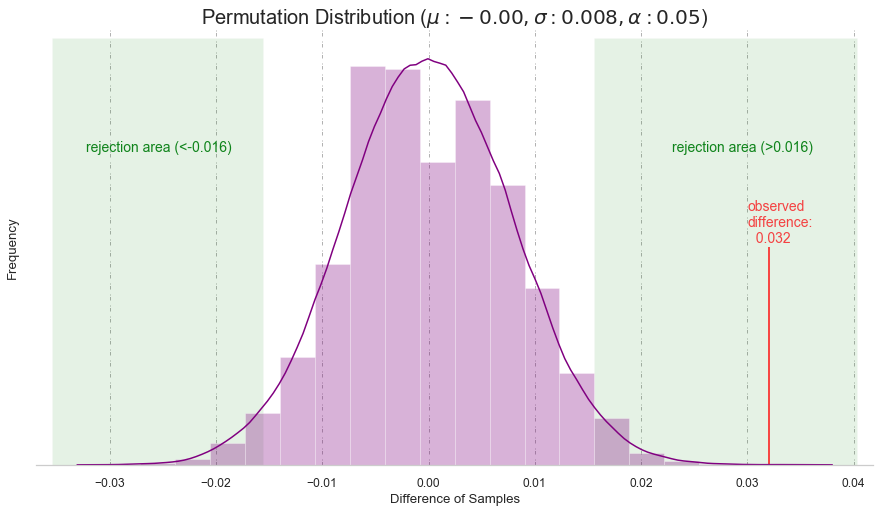

In [7]:
## Observed difference
observed = np.mean(awdf) - np.mean(abdf)

## permute the sample of 50,000 times and calculate the difference of proportion of call
perm_replicates = draw_perm_reps(awdf, abdf, size=50000)

## define significance level: 0.05
alpha = 0.05
## calculate the p_value
p_value = np.sum(perm_replicates > observed) / len(perm_replicates)

## null hypothesis: there is NO significant racial discrimination in the job market
print("p-value:", p_value)
if p_value < alpha:
    print("The null hypothesis can be rejected: there is likely significant racial discrimination in the job market")
else:
    print("the null hypothesis cannot be rejected: there is NOT likely significant racial discrimination in the job market")

## calculate 95% confidence interval of permutation distribution
left, right = np.percentile(perm_replicates, [2.5, 97.5])
print("95% confidence interval of permutation distribution is [{:.3f}, {:.3f}]".format(left, right))

## calculate margine of error: me
me = (right - left) / 2
print("Margin of error at 95% confidence is: {:.3f}".format(me))

## visualization
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid", font_scale=1.1)

## distribution plot
ax = sns.distplot(perm_replicates, bins=20, color = 'purple', hist_kws=dict(alpha=0.3))

plt.title(r'Permutation Distribution ($\mu: {:.2f}, \sigma: {:.3f}, \alpha: 0.05$)'.format(np.mean(perm_replicates), np.std(perm_replicates)), fontsize=20)
plt.xlabel('Difference of Samples')
plt.ylabel('Frequency')
ax.yaxis.set_ticklabels([])

y = ax.get_ylim()[1]
ax.fill_between([min(perm_replicates)-0.005, left], 0, y, facecolor='green', alpha=0.1)
ax.fill_between([right, max(perm_replicates)+0.005], 0, y, facecolor='green', alpha=0.1)

ax.text(0.06, 0.72, 'rejection area (<{:.3f})'.format(left), 
         transform=ax.transAxes, color='#0f841b', fontsize=14);
ax.text(0.76, 0.72, 'rejection area (>{:.3f})'.format(right), 
         transform=ax.transAxes, color='#0f841b', fontsize=14);

ax.vlines(observed, 0,0.5, transform=ax.get_xaxis_transform(), alpha=0.7, color='red', linewidth=2)
ax.text(0.85, 0.51, "observed\ndifference:\n  {:.3f}".format(observed), 
        transform=ax.transAxes, color="#f44242", fontsize=14)

sns.despine(right=True, top=True, left=True)
ax.grid(color="grey", linestyle=(0, (3.5, 1.5, 1, 5)), alpha=0.6)
ax.yaxis.grid(False)
ax.margins(0.02)

According to permutation test, p-value is very negligible which means we reject the null hyothesis and implies there is likely significant racial discrimination in the job market. 

### Chi-squared test
I use chi-squred test only to compare the result with that of permutation test, and will use scipy.stat.chi2_contingency. For detailed explanation for Chi-squared test, follow this [link][1] and reference this [examples][2]. 

[1]: https://en.wikipedia.org/wiki/Chi-squared_test
[2]: http://math.hws.edu/javamath/ryan/ChiSquare.html

In [8]:
## compute a frequency table of call and race
table = pd.crosstab(index=df['call'], columns=df['race'])

table

race,b,w
call,,
0.0,2278,2200
1.0,157,235


In [9]:
## chi: the test statistic
## p: the p-value of the test
## dof: degrees of freedom (ref: observed.size - sum(observed.shape) + observed.ndim - 1)
## expected: the expected frequencies, based on the marginal sums of the table
chi, p, dof, expected = stats.chi2_contingency(table)

print("Chi-sqared value: {:.3f}".format(chi))
print("p-value:", p)
print("degrees of freedom:", dof)

Chi-sqared value: 16.449
p-value: 4.997578389963255e-05
degrees of freedom: 1


With 1 degree of freedom and a chi-square statistic of 16.5, looking these values up on the chi square chart yields a p-value of approx 5e-5. This is substantially less than 0, meaning we still reject the null hypothesis that there is no significant racial discrimination in the job market. The Chi-square test confirms what we derived using permutation test.

# Q4. Wrtie a story describing the statistical significance in the context or the original problem.
As the original problem argued, many people have been claiming that Americans are as racist as they were back in the late 1980s in the job market. For example, researchers at Northwestern University, Harvard, and the Institute for Social Research in Norway, looked at every available field experiment on hiring discrimination from 1989 through 2015. The researchers found that anti-black racism in hiring is unchanged since at least 1989. They concluded that, on average, "white applicants receive 36% more callbacks than equally qualified African Americans."

The original problem is in line with these argument of racism in the job market. In order to determine whether race has a significant impact on the rate of callbacks for resumes. From the tests above, it is clear that a black sounding name negativetly influences whether or not that person receives a callback. In short, statisitcally, there is a chance that there exists significant racial discrimination in the job market.

# Q5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

The analysis does not mean that race/name is the most important factor in callback success. All it means is that race, plays enough of a role to be statistically significant. Said another way, race has some influence on the outcome of the callback variable. More data is needed to determine if/what other factors may be influencing the outcome. That is, multivariate analysis must be performed on all supplied variables, as some may weigh more heavy on the resulting statistics than only race.